# Weight Matrix Generator
Author: Kathryn Monopoli

Last Updated: Sept-23-2020

This is the code to generate (train) the weight matrix for the siRNA design algorithm.

## Read in scn9a Data

In [2]:
import pandas as pd
# Read in sequence data 
# data_file = "sirna_screen_data_KL25082020.csv" # *****
data_file = "All_data_2023-12-05_scaled_cleaned_SCN9A.csv"

scn9a_data = pd.read_csv(data_file)
#display(scn9a_data)
expr_key = "Scaled_%UNT"

print(scn9a_data.filter(like='STDEV'))


         STDEV    STDEV.1
0     1.348082   0.000000
1     1.699551   0.000000
2     1.322552   0.000000
3     4.348083   0.000000
4     0.602710   0.000000
..         ...        ...
317   6.532009   3.375477
318   3.220840   2.647105
319  24.485956   3.967696
320  32.982573  10.026136
321   0.275781   2.145083

[322 rows x 2 columns]
0           inf
1           inf
2           inf
3           inf
4           inf
         ...   
317    1.935137
318    1.216740
319    6.171329
320    3.289659
321    0.128564
Length: 322, dtype: float64


# Data Manipulation

Fixing some incorrect column names and values
1. Replace column name 45mer - 14+21+10 with 45mer
2. Set Gene column to Gene Name

In [235]:

# Rename Columns
scn9a_data.rename(columns={'45mer - 14+21+10':'45mer'}, inplace=True)
"""
gene_names = []
# Capitalize all Duplex Names
scn9a_data['Duplex Name'] = scn9a_data['Duplex Name'].str.upper()

# Split on underscore to get only gene name
for duplex in scn9a_data['Duplex Name']:
    if duplex.count("_") == 1:
        gene_names.append(duplex.split("_")[0])
    else:
        gene_names.append("_".join(duplex.split("_", 2)[:2]))

# Sort Gene Name
scn9a_data['Gene Name'] = gene_names
"""
scn9a_data['Gene Name'] = scn9a_data['Gene']

print(scn9a_data[['45mer', expr_key, 'Gene Name']])

# Relevant Columns = Gene Name, 45mer, STDEV, "Scaled_%UNT"


                                             45mer  Scaled_%UNT Gene Name
0    UCGUCAUUGUUUUUGCGUAUUUAACAGAAUUUGUAAACCUAGGCA     0.000000     SCN9A
1    GAACCAGGCAAACAUUGAAGAAGCUAAACAGAAAGAAUUAGAAUU     0.452069     SCN9A
2    UCUGAGUGUGUUUGCACUAAUUGGACUACAGCUGUUCAUGGGAAA     8.334797     SCN9A
3    UAUUGAGAGCUUUGAAAACUAUUUCUGUAAUCCCAGGCCUGAAGA     8.353904     SCN9A
4    GUAUUGAGAGCUUUGAAAACUAUUUCUGUAAUCCCAGGCCUGAAG     9.095621     SCN9A
..                                             ...          ...       ...
317  AAAGGAAGAUGGAAUUAAUGACAUGUUCAAUUUUGAGACCUUUGG   110.202429     SCN9A
318  AUCUUGCAAUUACCAUUUGCAUAGUUUUAAACACAUUAUUUAUGG   112.060634     SCN9A
319  AUCUGGAAUUGCUCUCCAUAUUGGAUAAAAUUCAAAAAGUGUAUC   112.106549     SCN9A
320  GAGCUCAUUUAGUUCAGACAAUCUUACAGCAAUUGAAGAAGACCC   112.367155     SCN9A
321  UUUUAUUGUAAUGGAUCCUUUUGUAGAUCUUGCAAUUACCAUUUG   112.873548     SCN9A

[322 rows x 3 columns]


# Print some statistics about the scn9a dataset

In [236]:
import numpy as np
print(len(scn9a_data),"sequences total")
print("Average Expression (%):",np.mean(scn9a_data[expr_key]))
print("Min Expression (%):",min(scn9a_data[expr_key]))
print("Max Expression (%):",max(scn9a_data[expr_key]))
print("number of genes:",len(list(set(list(scn9a_data["Gene Name"])))))

# Determine number of sequences per gene
genes = list(set(list(scn9a_data["Gene Name"])))

num_seqs_per_gene = []
for g in genes:
    num_seqs_per_gene.append(len(scn9a_data[scn9a_data["Gene Name"]==g]))
    
print(int(round(np.mean(num_seqs_per_gene),0)),"sequences per gene on average")



322 sequences total
Average Expression (%): 64.90494021365528
Min Expression (%): 0.0
Max Expression (%): 112.8735485
number of genes: 1
322 sequences per gene on average


# Plot siRNA Expression

Text(0, 0.5, 'Target Expression (%)')

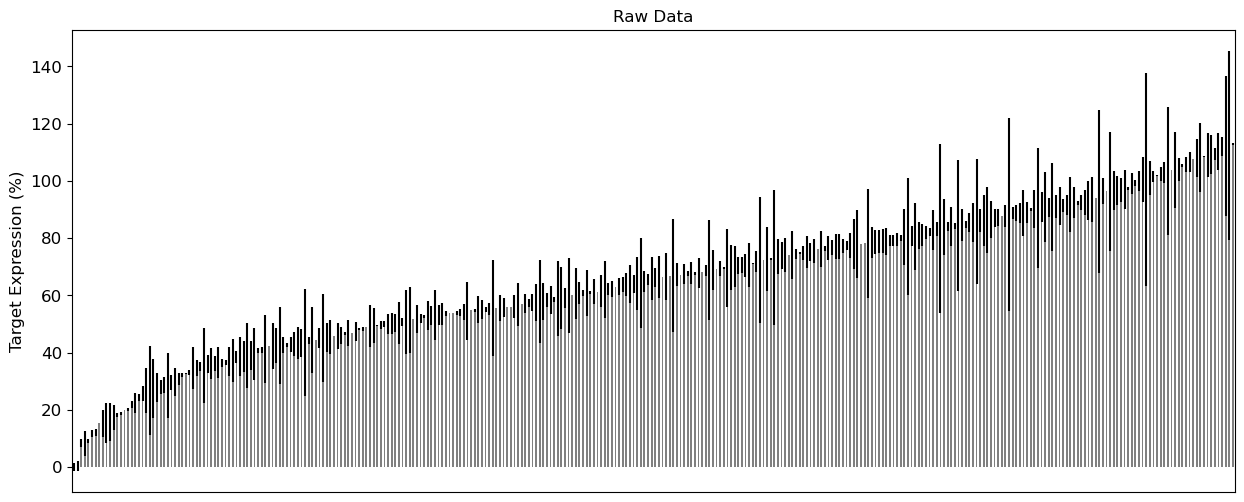

In [237]:
import statistics as stats
import numpy as np
# sort by expression %
scn9a_data.sort_values(by=[expr_key],inplace=True)
scn9a_data.reset_index(drop=True,inplace=True) # reindex 

# THERE ARE 2 STDEV COLUMNS
# plot data
import matplotlib.pyplot as plt
ax = scn9a_data.plot(
    y = expr_key,
#     x = "gene",
    kind='bar',
    yerr=scn9a_data["STDEV"],
    legend=False,
    figsize=(15,6),
    fontsize = 12,
    color="gray"
)
plt.title("Raw Data",fontsize = 12)
ax.xaxis.set_visible(False)# remove x-axis
# set title and axis labels
ax.set_ylabel("Target Expression (%)",fontsize = 12)

# Clean up data (optional)

### Remove Sequences with Standard Deviation above a chosen cutoff value

In [238]:
# Remove sequences with std dev > stdv_cutoff_pcnt of the expression itself
stdv_cutoff_pcnt = 0.30 # *******

n = len(scn9a_data) # number of sequences before removal
scn9a_data = scn9a_data[stdv_cutoff_pcnt*(scn9a_data[expr_key]) > scn9a_data["STDEV"]]
print("Removed sequences with stdev > "+str(int(stdv_cutoff_pcnt*100))+"% of the expression itself",
      "("+str(n-len(scn9a_data)),"sequences removed)")


Removed sequences with stdev > 30% of the expression itself (40 sequences removed)


### Remove Sequences with Expression above chosen cutoff values

In [239]:
# Removed sequences with Expression % > max_expr_cutoff_pcnt
max_expr_cutoff_pcnt = 125 # *******

n = len(scn9a_data) # number of sequences before removal
scn9a_data = scn9a_data[scn9a_data[expr_key] < max_expr_cutoff_pcnt]
print("Removed sequences with expression > "+str(int(max_expr_cutoff_pcnt))+"%",
      "("+str(n-len(scn9a_data)),"sequences removed)")



Removed sequences with expression > 125% (0 sequences removed)


# Plot Cleaned Data

282 sequences total
Average Expression (%): 66.6406631312305
Min Expression (%): 8.334796814
Max Expression (%): 112.8735485
number of genes: 1
282 sequences per gene on average


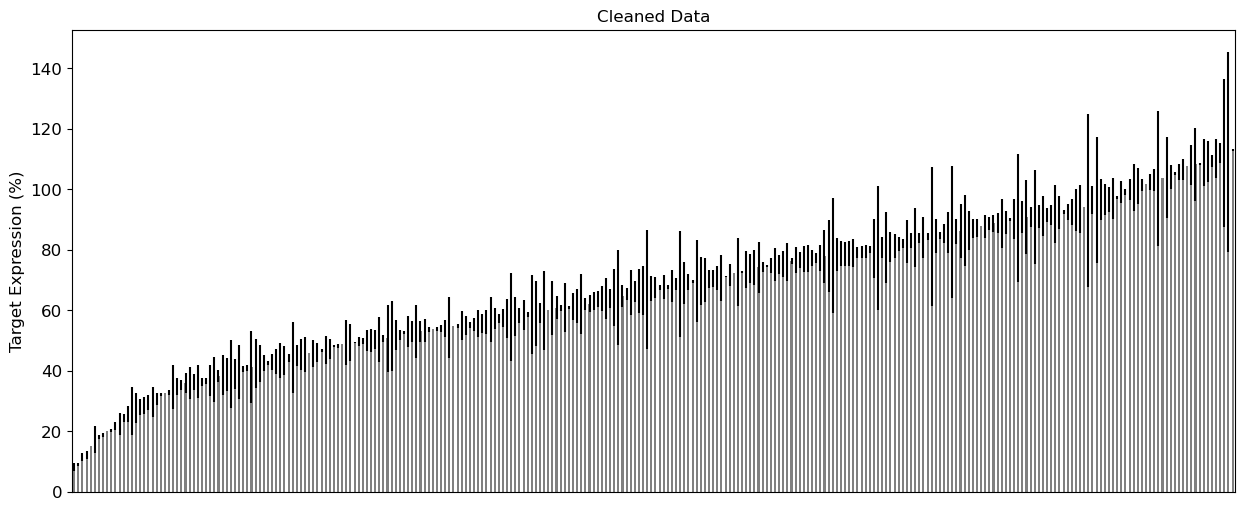

In [240]:
import statistics as stats
import numpy as np
# sort by expression %
scn9a_data.sort_values(by=[expr_key],inplace=True)
scn9a_data.reset_index(drop=True,inplace=True) # reindex 


# plot dataexpr_key
import matplotlib.pyplot as plt

ax = scn9a_data.plot(
    y = expr_key,
#     x = "gene",
    kind='bar',
    yerr=scn9a_data["STDEV"],
    legend=False,
    figsize=(15,6),
    fontsize = 12,
    color="gray"
)
plt.title("Cleaned Data",fontsize = 12)
ax.xaxis.set_visible(False)# remove x-axis
# set title and axis labels
ax.set_ylabel("Target Expression (%)",fontsize = 12)


# Print some statistics
print(len(scn9a_data),"sequences total")
print("Average Expression (%):",stats.mean(scn9a_data[expr_key]))
print("Min Expression (%):",min(scn9a_data[expr_key]))
print("Max Expression (%):",max(scn9a_data[expr_key]))
print("number of genes:",len(list(set(list(scn9a_data["Gene Name"])))))

# determine number of sequences per gene
genes = list(set(list(scn9a_data["Gene Name"])))

num_seqs_per_gene = []
for g in genes:
    num_seqs_per_gene.append(len(scn9a_data[scn9a_data["Gene Name"]==g]))
    
print(int(round(np.mean(num_seqs_per_gene),0)),"sequences per gene on average")



# Save cleaned up data to a file

In [241]:
out_file = data_file.split(".")[0]+("_cleaned_up.csv")

print("cleaned up data written to:",out_file)



cleaned up data written to: All_data_2023-12-05_scaled_cleaned_SCN9A_cleaned_up.csv


# Select Functional & Nonfunctional siRNA 
## (based on chosen cutoffs)

#### Tips:
* Look at the plot of the distribution of the Target Expression (above) to make decisions based on the spread of the data. Ex: if the data are spread evenly with expression values between 0 and 100% a good starting cutoffs might be 25% for functional siRNAs and 75% for nonfunctional. 
* Choosing a stricter cutoff for functional sequences will make it less likely that you are picking up noise, but there is a tradeoff as you might also be overfitting and then your weight matrix won't be widely applicable. 
* If you have larger datasets (>1000 siRNAs) you can use stricter cutoffs (<10% for functional sequences) without as much of a risk (note that the 1000 and 10% are just estimates included for clarification). 
* It is best practice to choose cutoffs that will lead to similarly sized functional and nonfunctional datasets, but you can choose different sizes and the training methods will still work. 
* You can also (and should!) play around with the cutoffs and run the [Plot Cutoffs](#plot_cutoffs) cell



In [242]:
func_cutoff = 30 # siRNAs with expression %'s LESS than this value will be included in training ******
nonfunc_cutoff = 70 # siRNAs with expression %'s GREATER than this value will be included in training ******

# label = ">"+str(func_cutoff)+" | <"+str(nonfunc_cutoff)

print("functional cutoff:",func_cutoff)
print("nonfunctional cutoff:",nonfunc_cutoff)


functional cutoff: 30
nonfunctional cutoff: 70


## Label siRNAs as Functional and Nonfunctional
 (mid designates middle siRNAs that were labeled as neither functional or nonfunctional)

In [243]:
import numpy as np
def isfunctional(x):
    if x<func_cutoff:
        return "functional"
    elif x>nonfunc_cutoff:
        return "nonfunctional"
    else:
        return "mid"
    
scn9a_data["label"] = scn9a_data[expr_key].apply(lambda x: isfunctional(x))



<a id='plot_cutoffs'></a>
# Plot Cutoffs


number of functional:  20
number of nonfunctional:  128
number of excluded:  134
total:  282
total used in evaluation (# functional + # nonfunctional): 148


Text(0, 0.5, 'Target Expression (%)')

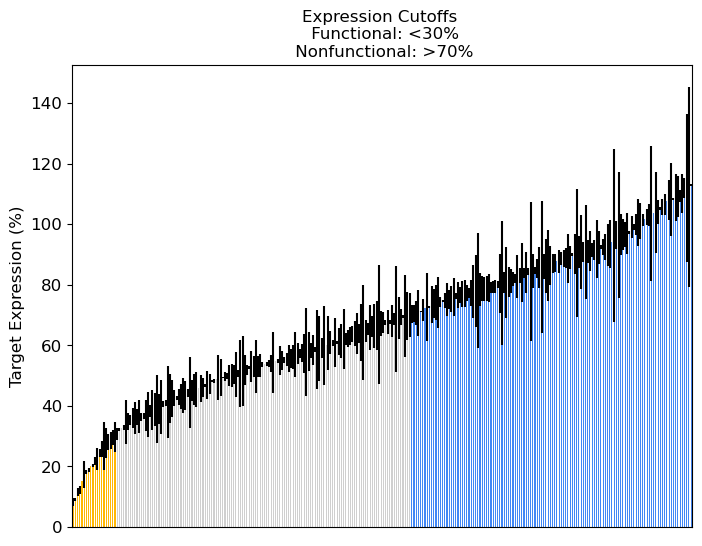

In [244]:
func_col = '#ffb805' # color of functional datapoints ****
nonfunc_col = '#4287f5' # color of nonfunctional datapoints ****
mid_col = '#cfcfcf' # color of excluded datapoints ****




# describe data
print("number of functional: ",(scn9a_data[scn9a_data["label"] == "functional"]).shape[0])
print("number of nonfunctional: ",(scn9a_data[scn9a_data["label"] == "nonfunctional"]).shape[0])
print("number of excluded: ",(scn9a_data[scn9a_data["label"] == "mid"]).shape[0])
print("total: ",scn9a_data.shape[0])
print("total used in evaluation (# functional + # nonfunctional):",(scn9a_data[scn9a_data["label"] == "functional"]).shape[0]+(scn9a_data[scn9a_data["label"] == "nonfunctional"]).shape[0])


# Plot expression cutoffs
import matplotlib.pyplot as plt
scn9a_data.sort_values(by=expr_key,inplace=True)
# color list to color by value 
colors=scn9a_data[scn9a_data["label"] == "functional"].shape[0]*[func_col]+scn9a_data[scn9a_data["label"] == "mid"].shape[0]*[mid_col]+scn9a_data[scn9a_data["label"] == "nonfunctional"].shape[0]*[nonfunc_col] 
ax = scn9a_data.plot(y = expr_key,kind='bar', yerr=scn9a_data["STDEV"],
                     legend=False,figsize=(8,6),fontsize = 12,
                     # color by value
                     color= colors 
                    )
# set title and axis labels
plt.title("Expression Cutoffs "+
          "\n Functional: <"+str(func_cutoff)+"%"+
          "\n Nonfunctional: >"+str(nonfunc_cutoff)+"%",
          fontsize = 12)
ax.xaxis.set_visible(False)# remove x-axis
ax.set_ylabel("Target Expression (%)",fontsize = 12)



# Select Training Set of chosen size
* The training set is a subset of the actual dataset with which we will run the weight matrix training.
* The training set is selected randomly from the full dataset.
* Remaining data (not included in training set) will be used to evaluate the weight matrix performance


In [245]:
training_set_size_pcnt = 0.75 # portion of dataset that will be included in training set as a decimal (ex: use 0.75 to represent 75%) ****

# Randomly select training set and set aside remaining data as the test (or evaluation) set
from sklearn.model_selection import train_test_split

# Introduce a random state for reproducability
random_state=50
sirna_train_data, sirna_test_data = train_test_split(scn9a_data, test_size=1-training_set_size_pcnt, random_state=random_state)
sirna_test_data.reset_index(drop=True, inplace=True)

#print("Training set selected with",len(sirna_train_data),"sequences")
#print("Test set contains ",len(sirna_test_data),"sequences")
sirna_test_data




,Gene Species,Exp Highdose,Oligo_ID,Screen,Gene,Transcript ID,Position number,Species,Source PWM,Gene_region,...,Flag?,Selected for IC50?,Selected for In vivo?,In vivo % KD (max),In vivo description,Scaled,Scaled_%UNT,Random Numbers,Gene Name,label
0,SCN9A_Human,94.393986,SCN9A_NM_002977.3_5886,Primary,SCN9A,NM_002977.3,5886,Human,Combined,AGATGGATTCTCTTCGTTCACAGATGGAAGAAAGGTTCATGTCTG,...,NaN,NaN,NaN,NaN,NaN,0.908968,90.896789,225,SCN9A,nonfunctional
1,SCN9A_Human,98.358199,SCN9A_NM_002977.3_3549,Tiling,SCN9A,NM_002977.3,3549,Human,Combined - tiling,GTCAATCATTTATTCACAATCCCAGCCTCACAGTGACAGTGCCAA,...,NaN,NaN,NaN,NaN,NaN,0.973340,97.333996,249,SCN9A,nonfunctional
2,SCN9A_Human,72.726972,SCN9A_NM_002977.3_6044,Tiling,SCN9A,NM_002977.3,6044,Human,Combined - tiling,AATGTCAAAAATATATCAAGTATATACATAAAAGATGGAGACAGA,...,NaN,NaN,NaN,NaN,NaN,0.557133,55.713255,145,SCN9A,mid
3,SCN9A_Human,69.404785,SCN9A_NM_002977.3_1361,Tiling,SCN9A,NM_002977.3,1361,Human,Combined - tiling,AACCCTGATTATGGCTACACGAGCTTTGACACTTTCAGCTGGGCC,...,NaN,NaN,NaN,NaN,NaN,0.503186,50.318590,278,SCN9A,mid
4,SCN9A_Human,84.677927,SCN9A_NM_002977.3_2516,Tiling,SCN9A,NM_002977.3,2516,Human,Combined - tiling,AAATTCAAAAAGTGTATCTATTTTATTGTAATGGATCCTTTTGTA,...,NaN,NaN,NaN,NaN,NaN,0.751196,75.119567,63,SCN9A,nonfunctional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,SCN9A_Human,62.425916,SCN9A_NM_002977.3_680,Primary,SCN9A,NM_002977.3,680,Human,Combined,CTTTCTCCTTTCAGTCCTCTAAGAAGAATATCTATTAAGATTTTA,...,NaN,NaN,NaN,NaN,NaN,0.389861,38.986097,189,SCN9A,mid
67,SCN9A_Human,85.843495,SCN9A_NM_002977.3_2702,Tiling,SCN9A,NM_002977.3,2702,Human,Combined - tiling,AAACTGATTGCCATGGATCCATATGAGTATTTCCAAGTAGGCTGG,...,NaN,NaN,NaN,NaN,NaN,0.770123,77.012251,235,SCN9A,nonfunctional
68,SCN9A_Human,58.738082,SCN9A_NM_002977.3_3883,Tiling,SCN9A,NM_002977.3,3883,Human,Combined - tiling,GATTGTTGAACACAGTTGGTTTGAAAGCTTCATTGTCCTCATGAT,...,NaN,Yes,NaN,NaN,NaN,0.329977,32.997683,291,SCN9A,mid
69,SCN9A_Human,105.188145,SCN9A_NM_002977.3_397,Tiling,SCN9A,NM_002977.3,397,Human,Combined - tiling,TTTCACAAAACAGTCTCTTGCCCTCATTGAACAACGCATTGCTGA,...,NaN,NaN,NaN,NaN,NaN,1.084247,108.424662,173,SCN9A,nonfunctional


### Save Training and Test sets to files

In [246]:
out_file = data_file.split(".")[0]+("_training.csv")
sirna_train_data.to_csv(out_file)
print("Training dataset written to:",out_file)

out_file = data_file.split(".")[0]+("_testing.csv")
sirna_test_data.to_csv(out_file)
print("Testing dataset written to:",out_file)



Training dataset written to: All_data_2023-12-05_scaled_cleaned_SCN9A_training.csv
Testing dataset written to: All_data_2023-12-05_scaled_cleaned_SCN9A_testing.csv


# Plot Training and Testing Set Cutoffs
Just to ensure that after selecting a subset our dataset still has the same distribution (it should because the training and testing sets were selected randomly)


Training Set:
number of functional:  15
number of nonfunctional:  96
number of excluded:  100
total:  211
total used in evaluation (# functional + # nonfunctional): 111


Text(0, 0.5, 'Target Expression (%)')

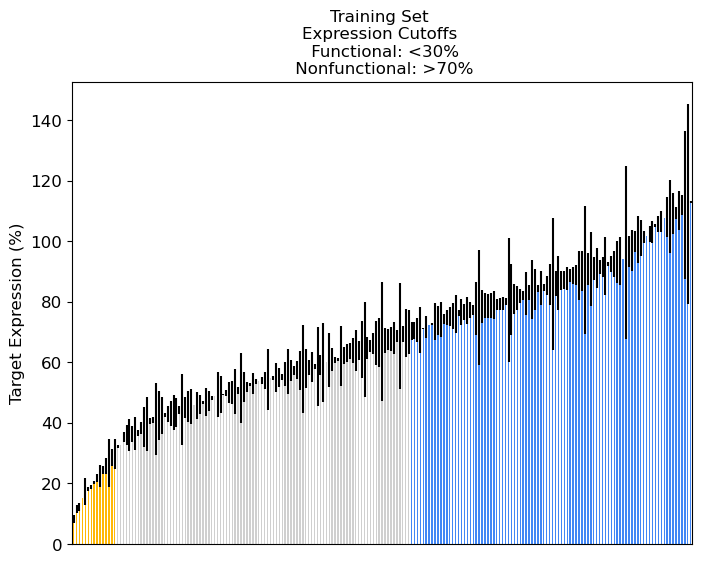

In [247]:
func_col = '#ffb805' # color of functional datapoints ****
nonfunc_col = '#4287f5' # color of nonfunctional datapoints ****
mid_col = '#cfcfcf' # color of excluded datapoints ****


# describe data
print("Training Set:")
print("number of functional: ",(sirna_train_data[sirna_train_data["label"] == "functional"]).shape[0])
print("number of nonfunctional: ",(sirna_train_data[sirna_train_data["label"] == "nonfunctional"]).shape[0])
print("number of excluded: ",(sirna_train_data[sirna_train_data["label"] == "mid"]).shape[0])
print("total: ",sirna_train_data.shape[0])
print("total used in evaluation (# functional + # nonfunctional):",(sirna_train_data[sirna_train_data["label"] == "functional"]).shape[0]+(sirna_train_data[sirna_train_data["label"] == "nonfunctional"]).shape[0])


# Plot expression cutoffs
import matplotlib.pyplot as plt
sirna_train_data = sirna_train_data.sort_values(by=expr_key)
# color list to color by value 
colors=sirna_train_data[sirna_train_data["label"] == "functional"].shape[0]*[func_col]+sirna_train_data[sirna_train_data["label"] == "mid"].shape[0]*[mid_col]+sirna_train_data[sirna_train_data["label"] == "nonfunctional"].shape[0]*[nonfunc_col] 
ax = sirna_train_data.plot(y = expr_key,kind='bar', yerr=sirna_train_data["STDEV"],
                     legend=False,figsize=(8,6),fontsize = 12,
                     # color by value
                     color= colors 
                    )
# set title and axis labels
plt.title("Training Set \nExpression Cutoffs "+
          "\n Functional: <"+str(func_cutoff)+"%"+
          "\n Nonfunctional: >"+str(nonfunc_cutoff)+"%",
          fontsize = 12)
ax.xaxis.set_visible(False)# remove x-axis
ax.set_ylabel("Target Expression (%)",fontsize = 12)






Test Set:
number of functional:  5
number of nonfunctional:  32
number of excluded:  34
total:  71
total used in evaluation (# functional + # nonfunctional): 37


Text(0, 0.5, 'Target Expression (%)')

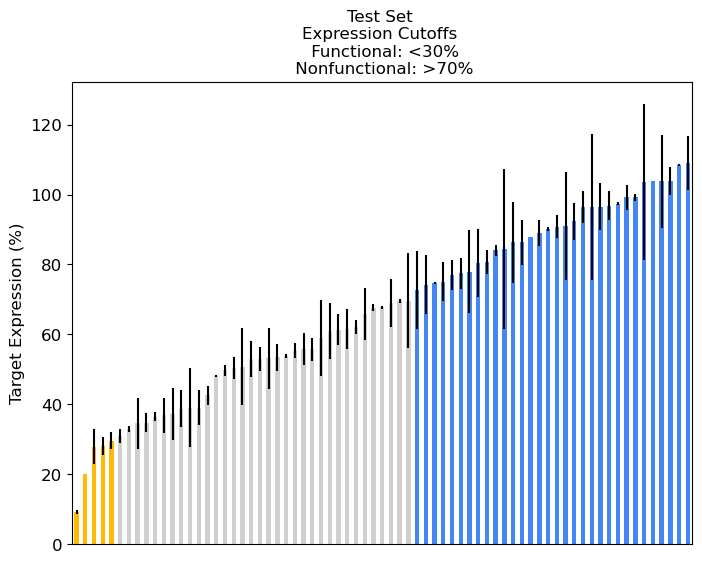

In [248]:
func_col = '#ffb805' # color of functional datapoints ****
nonfunc_col = '#4287f5' # color of nonfunctional datapoints ****
mid_col = '#cfcfcf' # color of excluded datapoints ****


# describe data
print("Test Set:")
print("number of functional: ",(sirna_test_data[sirna_test_data["label"] == "functional"]).shape[0])
print("number of nonfunctional: ",(sirna_test_data[sirna_test_data["label"] == "nonfunctional"]).shape[0])
print("number of excluded: ",(sirna_test_data[sirna_test_data["label"] == "mid"]).shape[0])
print("total: ",sirna_test_data.shape[0])
print("total used in evaluation (# functional + # nonfunctional):",(sirna_test_data[sirna_test_data["label"] == "functional"]).shape[0]+(sirna_test_data[sirna_test_data["label"] == "nonfunctional"]).shape[0])


# Plot expression cutoffs
import matplotlib.pyplot as plt
sirna_test_data = sirna_test_data.sort_values(by=expr_key)
# color list to color by value 
colors=sirna_test_data[sirna_test_data["label"] == "functional"].shape[0]*[func_col]+sirna_test_data[sirna_test_data["label"] == "mid"].shape[0]*[mid_col]+sirna_test_data[sirna_test_data["label"] == "nonfunctional"].shape[0]*[nonfunc_col] 
ax = sirna_test_data.plot(y = expr_key,kind='bar', yerr=sirna_test_data["STDEV"],
                     legend=False,figsize=(8,6),fontsize = 12,
                     # color by value
                     color= colors 
                    )
# set title and axis labels
plt.title("Test Set \nExpression Cutoffs "+
          "\n Functional: <"+str(func_cutoff)+"%"+
          "\n Nonfunctional: >"+str(nonfunc_cutoff)+"%",
          fontsize = 12)
ax.xaxis.set_visible(False)# remove x-axis
ax.set_ylabel("Target Expression (%)",fontsize = 12)





# Train the Weight Matrix

In [249]:
# Get frequencies per position of the entire dataset

train_seqs_all = pd.DataFrame([list(x) for x in sirna_train_data["45mer"]]) 
train_freqs_all = []
for i in range(0,train_seqs_all.columns[-1]+1):
    x = pd.DataFrame(train_seqs_all[i].value_counts(sort=False)).transpose()
    a = float(x["A"].item())
    u = float(x["U"].item())
    c = float(x["C"].item())
    g = float(x["G"].item())
#     print(x)
#     print("a:",a,"c:",c,"g:",g,"u:",u)
    train_freqs_all.append([a/len(train_seqs_all),u/len(train_seqs_all),c/len(train_seqs_all),g/len(train_seqs_all)])
# convert train_freqs_all from list to data_frame
train_freqs_all = pd.DataFrame(train_freqs_all,columns=["A","U","C","G"])
print("All Training Data Frequencies:")
train_freqs_all



All Training Data Frequencies:


,A,U,C,G
0,0.255924,0.398104,0.180095,0.165877
1,0.227488,0.402844,0.151659,0.218009
2,0.246445,0.331754,0.180095,0.241706
3,0.303318,0.327014,0.184834,0.184834
4,0.308057,0.331754,0.146919,0.213270
5,0.298578,0.327014,0.151659,0.222749
6,0.270142,0.312796,0.199052,0.218009
7,0.327014,0.322275,0.146919,0.203791
8,0.293839,0.350711,0.161137,0.194313
9,0.289100,0.369668,0.165877,0.175355


In [250]:
# Get frequencies per position for functional sequences
train_seqs_func = sirna_train_data[sirna_train_data["label"] == "functional"]["45mer"]

# split into individual columns
train_seqs_func = pd.DataFrame([list(x) for x in train_seqs_func])

train_freqs_func = []
for i in range(0,train_seqs_func.columns[-1]+1):
    x = pd.DataFrame(train_seqs_func[i].value_counts(sort=False)).transpose()
    if 'A' in x.columns:
        a = float(x["A"].item())
    else:
        a = 0
    if 'U' in x.columns:
        u = float(x["U"].item())
    else:
        u = 0
    if 'C' in x.columns:
        c = float(x["C"].item())
    else:
        c = 0
    if 'G' in x.columns:
        g = float(x["G"].item())
    else:
        g = 0
    #print(x)
    #print("a:",a,"c:",c,"g:",g,"u:",u)
    
    
    train_freqs_func.append([a/len(train_seqs_func),u/len(train_seqs_func),c/len(train_seqs_func),g/len(train_seqs_func)])

# convert train_freqs_func from list to data_frame
train_freqs_func = pd.DataFrame(train_freqs_func,columns=["A","U","C","G"])


# Get frequences per position for nonfuncional sequences
train_seqs_nonfunc = sirna_train_data[sirna_train_data["label"] == "nonfunctional"]["45mer"] #NOTE: 45mer is actually 45mer 
# split into individual columns
train_seqs_nonfunc = pd.DataFrame([list(x) for x in train_seqs_nonfunc])
train_freqs_nonfunc = []
for i in range(0,train_seqs_nonfunc.columns[-1]+1):
    x = pd.DataFrame(train_seqs_nonfunc[i].value_counts(sort=False)).transpose()
    if 'A' in x.columns:
        a = float(x["A"].item())
    else:
        a = 0
    if 'U' in x.columns:
        u = float(x["U"].item())
    else:
        u = 0
    if 'C' in x.columns:
        c = float(x["C"].item())
    else:
        c = 0
    if 'G' in x.columns:
        g = float(x["G"].item())
    else:
        g = 0
#     print(x)
#     print("a:",a,"c:",c,"g:",g,"u:",u)
    
    train_freqs_nonfunc.append([a/len(train_seqs_nonfunc),u/len(train_seqs_nonfunc),c/len(train_seqs_nonfunc),g/len(train_seqs_nonfunc)])
# convert train_freqs_nonfunc from list to data_frame
train_freqs_nonfunc = pd.DataFrame(train_freqs_nonfunc,columns=["A","U","C","G"])

# Subtract nonfuncional frequencies from funcional frequencies
freqs_subtracted = train_freqs_func - train_freqs_nonfunc
print("Functionl and Nonfunctional Frequencies subtracted:")
freqs_subtracted



Functionl and Nonfunctional Frequencies subtracted:


,A,U,C,G
0,0.150000,-0.062500,0.022917,-0.110417
1,-0.018750,-0.170833,0.264583,-0.075000
2,-0.014583,0.087500,0.079167,-0.152083
3,-0.179167,-0.010417,0.064583,0.125000
4,0.031250,0.077083,-0.027083,-0.081250
5,-0.035417,0.000000,-0.093750,0.129167
6,0.114583,0.020833,-0.075000,-0.060417
7,-0.154167,-0.077083,0.162500,0.068750
8,0.016667,-0.016667,0.064583,-0.064583
9,0.006250,0.025000,-0.043750,0.012500


## Generate P-values to determine which positions are important

For this we are trying to determine which positions matter most, so we simulate the event that we have a bunch of siRNAs with target regions (45mers) that have the same frequency distribution as that in the whole training dataset. We will compute the base frequencies of this random dataset. Then from there we can determine how different from random (i.e. how significant) each position is.

### Generate Random Sequences
(and compute associated statistics mean/median/standard deviation on the resulting base counts per position)

In [251]:
len(sirna_train_data[sirna_train_data["label"]=="nonfunctional"])

96

In [252]:
iter_num_func = len(sirna_train_data[sirna_train_data["label"]=="functional"])# iteration number (should the number of functional sequences in training dataset) ***
iter_num_nonfunc = len(sirna_train_data[sirna_train_data["label"]=="nonfunctional"])# iteration number (should the number of nonfunctional sequences in training dataset) ***

import numpy as np

# Generate random sequences using the per position base preferences of the entire dataset as the probabilities
def random_seq_gen(freqs,n): #freqs Dataframe of frequencies of A,U,C,G  
    '''Returns a list of n random sequences generated with the given per position frequency propbabilities (freq)'''
    BASES = ("A","U","C","G")
    l = len(freqs)
    seq_ls = []
    for i in range(0,n):
        seq = ''
        for k in range(0,l):
            # get position frequency for given positon (P)
            P = list(freqs.loc[k])
            # generate random sequence of length l given a per position frequency P
            seq+=''.join(np.random.choice(BASES, p=P)) 
            k+=1
        seq_ls.append(seq)
    
    return seq_ls

def compute_counts(seq_ls):
    ''' Compute base counts per position and return dataframe of per position base counts'''
    seq_ls_df = pd.DataFrame([list(x) for x in seq_ls])
    total_A = []
    total_U = []
    total_C = []
    total_G = []
    for i in range(len(seq_ls_df.columns)): # loop through columns
        a = (seq_ls_df[i][seq_ls_df[i] == "A"].count())
        u = (seq_ls_df[i][seq_ls_df[i] == "U"].count())
        c = (seq_ls_df[i][seq_ls_df[i] == "C"].count())
        g = (seq_ls_df[i][seq_ls_df[i] == "G"].count())
        # a,c,g,u = seq_ls_df[i].value_counts(sort=False) # does not work if one or more bases is not present at that possition
        total_A.append(a)
        total_U.append(u)
        total_G.append(g)
        total_C.append(c)
    ct_df = pd.DataFrame([total_A,total_U,total_G,total_C]).transpose()
    ct_df.columns = ["A","U","C","G"]
    return ct_df



def compute_stats(fn,ct_df_ls):
    '''Computes the provided numpy stats function fn (np.mean/np.median/np.std) from a list of per position base count dataframes'''
    stat_df = pd.DataFrame(
        ([fn([df["A"][j] for df in cts_df_ls_func]) for j in range(0,len(ct_df_ls[0]))], # Extract Column A, row j and computes the mean, loops through each dataframe in the list and through each column in each dataframe
        [fn([df["U"][j] for df in cts_df_ls_func]) for j in range(0,len(ct_df_ls[0]))], # Extract Column U, row j and computes the mean, loops through each dataframe in the list and through each column in each dataframe
        [fn([df["C"][j] for df in cts_df_ls_func]) for j in range(0,len(ct_df_ls[0]))], # Extract Column C, row j and computes the mean, loops through each dataframe in the list and through each column in each dataframe
        [fn([df["G"][j] for df in cts_df_ls_func]) for j in range(0,len(ct_df_ls[0]))]) # Extract Column G, row j and computes the mean, loops through each dataframe in the list and through each column in each dataframe
    ).transpose()
    stat_df.columns =["A","U","C","G"]
    return stat_df

import math
def compute_test_statistic(md_f,md_nf,std_f,std_nf,n_f,n_nf):
    return ((md_nf/n_nf)-(md_f/n_f))/math.sqrt( (((std_nf**2)/(n_nf**2))/n_nf) + (((std_f**2)/(n_f**2))/n_f))


# Generate Random Sequences corresponding to the number of functional sequences
cts_df_ls_func = [] 

# set random seed for reproducability
seed = 5
np.random.seed(seed) 
    
for i in range(0,iter_num_func):
    cts_df_ls_func.append(compute_counts(random_seq_gen(train_freqs_all,iter_num_func)))
print("Random sequence generation for Functional sequences complete, generated",iter_num_func*iter_num_func,"sequences")

# compute statistics
# mean_df_func = compute_stats(np.mean, cts_df_ls_func)
median_df_func = compute_stats(np.median, cts_df_ls_func)
std_df_func = compute_stats(np.std, cts_df_ls_func)

# Generate Random Sequences corresponding to the number of nonfunctional sequences
cts_df_ls_nonfunc = []
for i in range(0,iter_num_func):
    cts_df_ls_nonfunc.append(compute_counts(random_seq_gen(train_freqs_all,iter_num_nonfunc)))
print("Random sequence generation for Nonfunctional sequences complete, generated",iter_num_nonfunc*iter_num_nonfunc,"sequences")

# compute statistics
# mean_df_nonfunc = compute_stats(np.mean, cts_df_ls_nonfunc)
median_df_nonfunc = compute_stats(np.median, cts_df_ls_nonfunc)
std_df_nonfunc = compute_stats(np.std, cts_df_ls_nonfunc)





Random sequence generation for Functional sequences complete, generated 225 sequences
Random sequence generation for Nonfunctional sequences complete, generated 9216 sequences


### Generate Test Statistics
![test_statistic_equation](test_stat_equation.png)

In [253]:
# generate test statistics (one per base per position)
a_ls=[]
u_ls=[]
c_ls=[]
g_ls=[]
# loop through each position
for i in range(0,len(median_df_func)):
    a_ls.append(compute_test_statistic(median_df_func["A"][i],median_df_nonfunc["A"][i],std_df_func["A"][i],std_df_nonfunc["A"][i],iter_num_func,iter_num_nonfunc))
    u_ls.append(compute_test_statistic(median_df_func["U"][i],median_df_nonfunc["U"][i],std_df_func["U"][i],std_df_nonfunc["U"][i],iter_num_func,iter_num_nonfunc))
    c_ls.append(compute_test_statistic(median_df_func["C"][i],median_df_nonfunc["C"][i],std_df_func["C"][i],std_df_nonfunc["C"][i],iter_num_func,iter_num_nonfunc))
    g_ls.append(compute_test_statistic(median_df_func["G"][i],median_df_nonfunc["G"][i],std_df_func["G"][i],std_df_nonfunc["G"][i],iter_num_func,iter_num_nonfunc))
test_stats_df = pd.DataFrame((a_ls,u_ls,c_ls,g_ls)).transpose()
test_stats_df.columns =["A","U","C","G"]

display(test_stats_df)





,A,U,C,G
0,-8.097994,-14.941063,-6.451935,-7.375603
1,-8.007105,-11.175079,-8.988655,-6.965522
2,-4.722333,-7.003482,-4.678941,-6.411793
3,-9.033233,-20.756788,-4.008028,-4.494328
4,-7.375603,-7.200970,-6.524840,-4.832390
5,-6.752184,-13.590061,-9.393751,-3.336604
6,-12.022471,-10.896290,-7.164972,-9.209336
7,-8.172217,-7.930761,-7.161772,-2.669035
8,-10.676140,-11.732430,-7.302213,-4.274529
9,-13.075547,-11.212189,-4.402409,-4.349894


### Generate P-Values from Test Statistics

In [254]:
# generate p-values from test statistics
from scipy.stats import t
dof = iter_num_func+iter_num_nonfunc-2 # degrees of freedom

def compute_p_value(test_stat,dof):
    return 2*t.cdf(-1*abs(test_stat),dof) # distribution function

# generate test statistics (one per base per position)
a_ls=[]
u_ls=[]
c_ls=[]
g_ls=[]
# loop through each position
for i in range(0,len(test_stats_df)):
    a_ls.append(compute_p_value(test_stats_df["A"][i],dof))
    u_ls.append(compute_p_value(test_stats_df["U"][i],dof))
    c_ls.append(compute_p_value(test_stats_df["C"][i],dof))
    g_ls.append(compute_p_value(test_stats_df["G"][i],dof))
p_vals_df = pd.DataFrame((a_ls,u_ls,c_ls,g_ls)).transpose()
p_vals_df.columns =["A","U","C","G"]

display(p_vals_df)

# TODO: convert NaNs


,A,U,C,G
0,8.708610e-13,3.869250e-28,3.131476e-09,3.397149e-11
1,1.387327e-12,8.800477e-20,8.623014e-15,2.598517e-10
2,6.983086e-06,2.155948e-10,8.331735e-06,3.792086e-09
3,6.831278e-15,1.151681e-39,1.123145e-04,1.746928e-05
4,3.397149e-11,8.116971e-11,2.209203e-09,4.443118e-06
5,7.371043e-10,3.314965e-25,1.033701e-15,1.160476e-03
6,1.048542e-21,3.806896e-19,9.705421e-11,2.718406e-15
7,5.948791e-13,2.049449e-12,9.860680e-11,8.769315e-03
8,1.212104e-18,4.755192e-21,4.902656e-11,4.118420e-05
9,4.560776e-24,7.243185e-20,2.508610e-05,3.078393e-05


## Build Weight Matrix

In [255]:
p_value_cutoff = 1e-5 # ****
#  Bonferroni correction for multiple comparisons
p_value_cutoff = p_value_cutoff**4 

p_value_data = p_vals_df
freq_sub_data = freqs_subtracted

# for each element in p_value_data, if < than p_value_cutoff set to 1, else set to 0
def convert_p_val_cutoff(x):
    if(x<p_value_cutoff):
        return 1
    else:
        return 0

p_value_data = p_value_data.map(convert_p_val_cutoff)

# convert freq subtracted values to weights
def convert_sub_to_freq(x):
    return(int(x*100))

freq_sub_data = freq_sub_data.map(convert_sub_to_freq)


# multiply the dataframes to get the final weight matrix

weight_matrix = pd.DataFrame(freq_sub_data.values*p_value_data.values, columns=freq_sub_data.columns, index=freq_sub_data.index)



out_weight_matrix = pd.DataFrame(weight_matrix)
out_weight_matrix["split_seed"] = random_state
out_weight_matrix["pop_seed"] = seed
out_weight_matrix["position"] = (out_weight_matrix.index + 1)

print("Weight Matrix:")
display(out_weight_matrix)

# save weight matrix to file
pssm_outfile=f"pssms/pssm_scn9a_data_2023-12-05_split_seed-{random_state}_pop_seed-{seed}.csv"
out_weight_matrix.to_csv(pssm_outfile,index=False)
print("Weight Matrix file saved to:",pssm_outfile)





Weight Matrix:


,A,U,C,G,split_seed,pop_seed,position
0,0,-6,0,0,50,5,1
1,0,0,0,0,50,5,2
2,0,0,0,0,50,5,3
3,0,-1,0,0,50,5,4
4,0,0,0,0,50,5,5
5,0,0,0,0,50,5,6
6,11,0,0,0,50,5,7
7,0,0,0,0,50,5,8
8,0,-1,0,0,50,5,9
9,0,0,0,0,50,5,10


Weight Matrix file saved to: pssms/pssm_scn9a_data_2023-12-05_split_seed-50_pop_seed-5.csv


In [256]:
testing = weight_matrix.groupby(by=["U"]).sum()
print(testing)

      A  C  G
U            
-6    0  0  0
-1    0  0  0
 0   13  8  0
 12   0  0  0
 14   0  0  0


# Assess Weight Matrix Performance (on holdout Test Dataset)


### Score sequences with the new weight matrix

In [257]:


def score_sequences(df,weight_matrix):
    # add new column to df for scores
    df["score"] = -999 # initialize to score -999
    seqs = list(df["45mer"])

    # convert weight_matrix to list of lists (4 elements per list - 45 elements in outer list)
    weights = [list(x) for x in weight_matrix.to_numpy()]
    
    score_ls = []
    j=0 # keeps track of seqs
    while(j<len(seqs)):
        x=seqs[j]
        seq_ls = list(x)
        score = 0
        i = 0 # keeps track of positions in 45mer

        while i<45:
            b = seq_ls[i]
            pos_score = 0
            if(b == "A"):
                pos_score=weights[i][0]
            elif(b == "U" or b == "T"):
                pos_score=weights[i][1]
            elif(b == "C"):
                pos_score=weights[i][2]
            elif(b == "G"):
                pos_score=weights[i][3]
            score+=pos_score
            i+=1

        df.loc[j, "score"] = score
            
        j+=1
        score_ls.append([x,score])

    return df

# Determine actual activity of sequences in test set
def get_activity(df,func_cutoff):
    # add new column to df for functionality
    df["activity"] = "" # initialize to empty string
    exprs = list(df[expr_key])
    j=0 # keeps track of each siRNA
    while(j<len(df)):
        func = "X"
        x=exprs[j]

        if x < func_cutoff:
            func = "functional"
        else:
            func = "nonfunctional"

        df.loc[j, "activity"] = func
        j+=1

    return df

sirna_test_data

# Compute actual activity of the test sequences (based on the chosen functional cutoff %)
get_activity(sirna_test_data,func_cutoff)
# Score test set data with new weight matrix
score_sequences(sirna_test_data,weight_matrix)


,Gene Species,Exp Highdose,Oligo_ID,Screen,Gene,Transcript ID,Position number,Species,Source PWM,Gene_region,...,Selected for In vivo?,In vivo % KD (max),In vivo description,Scaled,Scaled_%UNT,Random Numbers,Gene Name,label,activity,score
57,SCN9A_Human,44.018517,SCN9A_NM_002977.3_1007,Primary,SCN9A,NM_002977.3,1007,Human,Combined,GTATTGAGAGCTTTGAAAACTATTTCTGTAATCCCAGGCCTGAAG,...,NaN,NaN,NaN,0.090956,9.095621,51,SCN9A,functional,nonfunctional,5
25,SCN9A_Human,50.758920,SCN9A_NM_002977.3_2532,Primary,SCN9A,NM_002977.3,2532,Human,Combined,TCTATTTTATTGTAATGGATCCTTTTGTAGATCTTGCAATTACCA,...,NaN,NaN,NaN,0.200409,20.040886,6,SCN9A,functional,nonfunctional,5
37,SCN9A_Human,55.553458,SCN9A_NM_002977.3_679,Primary,SCN9A,NM_002977.3,679,Human,Combined,GCTTTCTCCTTTCAGTCCTCTAAGAAGAATATCTATTAAGATTTT,...,NaN,NaN,NaN,0.278264,27.826398,267,SCN9A,functional,nonfunctional,12
42,SCN9A_Human,55.651584,SCN9A_NM_002977.3_1351,Primary,SCN9A,NM_002977.3,1351,Human,Combined,AATTGGCAGAAACCCTGATTATGGCTACACGAGCTTTGACACTTT,...,Yes,NaN,NaN,0.279857,27.985737,271,SCN9A,functional,nonfunctional,62
36,SCN9A_Human,56.656961,SCN9A_NM_002977.3_686,Tiling,SCN9A,NM_002977.3,686,Human,Combined - tiling,CCTTTCAGTCCTCTAAGAAGAATATCTATTAAGATTTTAGTACAC,...,NaN,NaN,NaN,0.296183,29.618299,234,SCN9A,functional,nonfunctional,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,SCN9A_Human,102.333227,SCN9A_NM_002977.3_5324,Primary,SCN9A,NM_002977.3,5324,Human,Combined,TATGTTAAAAAGGAAGATGGAATTAATGACATGTTCAATTTTGAG,...,NaN,NaN,NaN,1.037888,103.788762,256,SCN9A,nonfunctional,nonfunctional,-4
12,SCN9A_Human,102.344560,SCN9A_NM_002977.3_2481,Primary,SCN9A,NM_002977.3,2481,Human,Combined,AATTCTTGATCTGGAATTGCTCTCCATATTGGATAAAATTCAAAA,...,NaN,NaN,NaN,1.038072,103.807165,272,SCN9A,nonfunctional,nonfunctional,11
23,SCN9A_Human,102.443172,SCN9A_NM_002977.3_4211,Primary,SCN9A,NM_002977.3,4211,Human,Combined,CCTCTAAGAGCCTTATCTAGATTTGAAGGAATGAGGGTCGTTGTG,...,NaN,NaN,NaN,1.039673,103.967294,245,SCN9A,nonfunctional,nonfunctional,29
69,SCN9A_Human,105.188145,SCN9A_NM_002977.3_397,Tiling,SCN9A,NM_002977.3,397,Human,Combined - tiling,TTTCACAAAACAGTCTCTTGCCCTCATTGAACAACGCATTGCTGA,...,NaN,NaN,NaN,1.084247,108.424662,173,SCN9A,nonfunctional,nonfunctional,29


# Plot Algorithm Performance and Compare to UMass Data Generated PSSM

Area under curve: 0.06768710791459479
Absolute differences of base pairs:
 A    293
U    290
C    181
G    197
dtype: int64
Total sum of absolute differences: 961


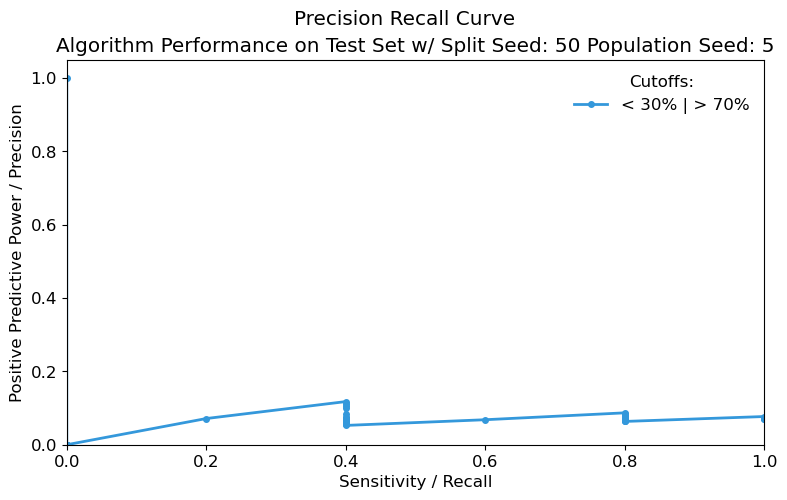

In [258]:
from sklearn.metrics import precision_recall_curve, auc
#from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve( sirna_test_data.activity, 
                                                       sirna_test_data.score,pos_label="functional")

# Find AUC
auc_precision_recall = auc(recall, precision)
print("Area under curve:", auc_precision_recall)

# Find absolute difference between generated matrix and original
umass = pd.read_csv("umass_weight_matrix.csv")
difference = umass - weight_matrix
abs_base_diff = difference.abs().sum()
print("Absolute differences of base pairs:\n",abs_base_diff)
print("Total sum of absolute differences:", abs_base_diff.sum())

# Plot Curve
import pylab as pl
color = "#3498db"
# label for data (Based on cutoffs used in matrix)
lab = "< "+str(func_cutoff)+"% | > "+str(nonfunc_cutoff)+"%"
pl.rcParams["figure.figsize"] = (9,5)
pl.rcParams.update({'font.size': 12})
pl.plot(recall,precision, marker='.',linewidth=2, markersize=8,color=color,label = lab)
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.00])
pl.xlabel('Sensitivity / Recall')
pl.ylabel('Positive Predictive Power / Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.00])
pl.title("Algorithm Performance on Test Set w/ Split Seed: "+str(random_state)+" Population Seed: "+str(seed))
pl.suptitle("Precision Recall Curve")
pl.legend(title="Cutoffs:",frameon=False)#loc="lower left")

outfile = f"plots/pr-rc_scn9a_data_2023-12-05_split_seed-{random_state}_pop_seed-{seed}.png"
plt.savefig(outfile)
#plt.savefig("")

